In [1]:
from keras.callbacks import History
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras.datasets import cifar10
from keras.engine import training
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dropout, Activation, Average
from keras.losses import categorical_crossentropy
from keras.models import Model, Input
from keras.optimizers import Adam
from keras.utils import to_categorical
from tensorflow.python.framework.ops import Tensor
from typing import Tuple, List
import glob
import numpy as np
import os

E:\Users\Arnab\Anaconda3\Lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
from keras.models import load_model
import keras

In [3]:
from keras.models import Model
import tensorflow as tf

def top_3_accuracy(y_true, y_pred):
    return tf.keras.metrics.top_k_categorical_accuracy(y_true, y_pred, k = 3)

dependencies = {
    'top_3_accuracy' : top_3_accuracy
}
#model1 = load_model('new_cmt_ins_aug.h5')
#model2 = load_model('new_cmt_res_aug.h5')
#model3 = load_model('new_cmt_dense_aug.h5')
#model4 = load_model('inception_no_aug.h5')
#model5 = load_model('2_1_no_aug.h5')
#model6 = load_model('3_1_no_aug.h5')
model1 = load_model('ins_no_curr.h5', custom_objects=dependencies)
model2 = load_model('res.h5', custom_objects=dependencies)
model3 = load_model('den.h5', custom_objects=dependencies)
model4 = load_model('ins_no_curr_no.h5', custom_objects=dependencies)
model5 = load_model('res_no.h5', custom_objects=dependencies)
model6 = load_model('den_no.h5', custom_objects=dependencies)

In [4]:
model1.name = '1'
model2.name = '2'
model3.name = '3'
model4.name = '4'
model5.name = '5'
model6.name = '6'

In [5]:
def ensembelModel(models, model_input):
    yModels = [model(model_input) for model in models]
    #outputs = [model.outputs[0] for model in models]
    #y = Average()(outputs)
    y = keras.layers.average(yModels)
    modelE = Model(inputs=model_input, outputs=y)
    return modelE

In [6]:
models = [model1, model2, model3, model4, model5, model6]
inputs = Input(shape=models[0].input_shape[1:])    
modelens = ensembelModel(models, inputs)
#modelens = ensembelModel([modelens1, modelens2, modelens3, modelens4, modelens5, modelens6], inputs)

In [7]:
modelens.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
1 (Model)                       (None, 231)          17703079    input_1[0][0]                    
__________________________________________________________________________________________________
2 (Model)                       (None, 231)          9036391     input_1[0][0]                    
__________________________________________________________________________________________________
3 (Model)                       (None, 231)          1425447     input_1[0][0]                    
__________________________________________________________________________________________________
4 (Model) 

In [8]:
modelens.save('ensembled_all.h5')

In [9]:
#model = load_model('ensembled.h5')

In [10]:
from keras.preprocessing.image import ImageDataGenerator
import time
from keras.callbacks import TensorBoard
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import csv
from keras.utils.vis_utils import plot_model
from keras.callbacks import History
from matplotlib import pyplot as plt


In [11]:
i=32
train_data = ImageDataGenerator(rescale=1./255)#, rotation_range = 10, shear_range = .1 , zoom_range = .1, width_shift_range = .1, height_shift_range = .1)
test_data = ImageDataGenerator(rescale=1./255)

training = train_data.flow_from_directory('TrainAll',target_size=(i,i), batch_size=64,class_mode='categorical')
test = train_data.flow_from_directory('TestAll',target_size=(i,i), batch_size=64,class_mode='categorical')
#opt= Adam(lr=step_decay(epochs), beta_1=0.9, beta_2=0.999)


Found 49282 images belonging to 231 classes.
Found 13254 images belonging to 231 classes.


In [12]:
from keras.callbacks import History, LearningRateScheduler
import math


modelens.trainable = False

epochs = 50
def step_decay(epochs):
    initial_lrate = 0.0005
    drop = 0.5
    epochs_drop = 5.0
    lrate = initial_lrate * math.pow(drop,  
           math.floor((1+epochs)/epochs_drop))
    return lrate

lrate=LearningRateScheduler(step_decay)

opt= Adam()
modelens.compile(optimizer=opt, loss = "categorical_crossentropy", metrics= ["accuracy", top_3_accuracy])
#modelens.evaluate_generator(test)
#modelens.fit_generator(training, epochs=1, validation_data=test)

In [13]:
modelens.evaluate_generator(test)

[0.056278768087586466, 0.9839293798098687, 0.9975856345254263]

In [14]:
i = 32
test_data = ImageDataGenerator(rescale=1./255)
testp = test_data.flow_from_directory('TestAll',target_size=(i,i), batch_size=64,class_mode='categorical',shuffle=False)        
t_pred = modelens.predict_generator(testp)
pred = np.argmax(t_pred, axis=1)
print(pred)
print('Confusion Matrix')
conf = confusion_matrix(testp.classes, pred)
print(conf)
print('Classification Report')
target_names = ['0', '1', '2', '3', '4', '5','6', '7', '8', '9']
for k in range(10,231):
    k1=k
    target_names.append(str(k1))
f1 = classification_report(testp.classes, pred, target_names=target_names)
print(f1)

Found 13254 images belonging to 231 classes.
[  0   0   0 ... 230 230 230]
Confusion Matrix
[[49  0  0 ...  0  0  0]
 [ 0 50  0 ...  0  0  0]
 [ 0  0 48 ...  0  0  0]
 ...
 [ 0  0  0 ... 58  0  0]
 [ 0  0  0 ...  0 48  0]
 [ 0  0  0 ...  0  0 49]]
Classification Report
             precision    recall  f1-score   support

          0       1.00      0.98      0.99        50
          1       0.98      1.00      0.99        50
          2       1.00      1.00      1.00        48
          3       1.00      1.00      1.00        47
          4       1.00      0.97      0.99        40
          5       1.00      0.98      0.99        52
          6       1.00      1.00      1.00        43
          7       1.00      0.90      0.95        41
          8       0.95      1.00      0.98        41
          9       1.00      1.00      1.00        40
         10       0.98      1.00      0.99        47
         11       0.96      1.00      0.98        49
         12       0.98      1.00      0.

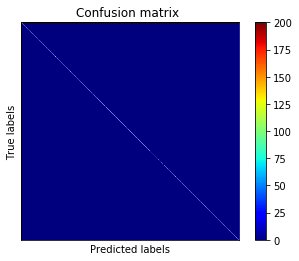

In [15]:
plt.imshow(conf, cmap=plt.cm.jet)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.xticks([], [])
plt.yticks([], [])
plt.title('Confusion matrix ')
plt.colorbar()
plt.show()
#print(model.summary())

In [16]:
truth = []

for i in range(208):
    x, y = next(testp)
    #predd.append(modelens.predict_generator(x, steps=64))
    truth.append(y) 

#predd = np.concatenate(predd)
truth = np.concatenate(truth)

In [17]:
truth.shape

(13254, 231)

In [18]:
y.shape[0]

6

In [19]:
pred_t = pred
pred_t.shape

(13254,)

In [20]:
import sys
import numpy
numpy.set_printoptions(threshold=20)

In [21]:
print(pred.shape)
pred1 = np.expand_dims(pred, axis=1) # make same shape as y_test
print(pred1)
b = np.zeros((pred1.size, pred1.max()+1))
b[np.arange(pred1.size),pred1] = 0
print(b)
print(truth)
error = np.sum(np.not_equal(b, truth)) / truth.shape[0] 

(13254,)
[[  0]
 [  0]
 [  0]
 ...
 [230]
 [230]
 [230]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]


In [22]:
error

1.0

In [23]:
#import tensorflow as tf
#tf.enable_eager_execution()
cce = keras.losses.CategoricalCrossentropy()
cce(truth, b).numpy()

AttributeError: module 'keras.losses' has no attribute 'CategoricalCrossentropy'

In [ ]:
import cv2

In [ ]:
img = cv2.imread('01_0001_0_15_0916_0438_2.png')

In [ ]:
img = cv2.resize(img, (32,32))

In [ ]:
img = np.reshape(img, [1, 32, 32, 3])

In [ ]:
classes = modelens.predict(img)
print(np.argmax(classes, axis=1))

In [ ]:
cnt = 1
for i in conf:
    for j in range(0, len(i)):
        if((cnt != (j+1)) & (i[j] != 0)):
            print(str(cnt) + "   " + str(j+1) + " = " +str(i[j]))
    cnt = cnt + 1

In [ ]:
i

In [25]:
import pandas as pd
df = pd.DataFrame(conf)

In [26]:
df

,0,1,2,3,4,5,6,7,8,9,...,221,222,223,224,225,226,227,228,229,230
0,49,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,50,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,48,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,47,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,39,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,51,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
6,0,0,0,0,0,0,43,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,37,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,41,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,40,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
df.